In [1]:
#%% suggest neurons for next session based on previous sessions
import os
import BCI_analysis
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from scipy.io import savemat
from scipy.stats import zscore
import shutil
import matplotlib.pyplot as plt

use_scalar_f0 = False

sessionwise_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba'
s2p_base_dir = '/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim'
raw_scanimage_dir = '/home/jupyter/bucket/Data/Calcium_imaging/raw/Bergamo-2P-Photostim'
bpod_path = '/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/'

#next_session_dir = '/home/jupyter/bucket/Data/Calcium_imaging/next_session'

maximum_decrease_in_f0 = .25 # if decreases above this amount will be thrown out
step_back = 60
step_forward = 300



use_red_channel = False
zscore_dff = False


subjects = ['BCI_58','BCI_59','BCI_60','BCI_59']
fovs = ['FOV_01','FOV_01','FOV_01','FOV_02']
subjects = ['BCI_59']
fovs = ['FOV_03']
multi_session_dict = {'mouse':[],
                     'session':[],
                      'fov':[],
                      'mat_idx':[],
                     'cn':[],
                      'cn_previous':[],
                     'DLC_aligned':[],
                     'F':[],
                     'trial_end_frames':[],
                     'F_original':[],
                     'F_original_pre_task':[],
                     'trial_start_original':[],
                     'trial_start_original_pre_task':[],
                     'reward_original':[],
                     'reward_original_pre_task':[],
                     'sampling_rate':[],
                     'photostim_distance':[],
                     'photostim_slm_distance':[],
                     'photostim_amplitude':[],
                     'photostim_amplitude_error':[],                      
                     'photostim_group':[],
                     'photostim_cell':[],
                     'F0':[]}

for subject,fov in zip(subjects,fovs):
    next_session_dir = '/home/jupyter/bucket/Data/Calcium_imaging/next_session/{}-{}/'.format(subject, fov)
    files = os.listdir(os.path.join(sessionwise_base_dir,subject))
    data_dict = {}
    sessions = []
    stat = np.load(os.path.join(s2p_base_dir,subject,fov,'stat.npy'),allow_pickle=True).tolist()
    stat_rest = np.load(os.path.join(s2p_base_dir,subject,fov,'stat_rest.npy'),allow_pickle=True).tolist()
    for file in files: ### NOT ALL FILES?? - 

        if fov in file:
            session = file[len(subject)+1:-1*(len(fov)+5)]
            sessions.append(session)
            data_dict[session] = BCI_analysis.io_python.read_sessionwise_npy(os.path.join(sessionwise_base_dir,subject,file))
            F0 = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F0.npy'))
            if use_red_channel:
                F = np.load(os.path.join(s2p_base_dir,subject,fov,session,'F_chan2.npy'))
                data_dict[session]['F_sessionwise'] =  F
                dff = (F-F0)/F0
                data_dict[session]['dff_sessionwise'] = dff


            if any(np.nanmean(F0/np.nanmedian(F0[:,:10000],1)[:,np.newaxis],0)<1-maximum_decrease_in_f0):
                throw_out_idx = np.where(np.nanmean(F0/np.nanmedian(F0[:,:10000],1)[:,np.newaxis],0)<1-maximum_decrease_in_f0)[0][0]
            else:
                throw_out_idx = data_dict[session]['dff_sessionwise'].shape[1]
            throw_out_idx = data_dict[session]['dff_sessionwise'].shape[1]    
            print('{}% discarded due to f0 rundown'.format(round(100*(1-(throw_out_idx/data_dict[session]['dff_sessionwise'].shape[1])))))
            data_dict[session]['F_sessionwise'] = data_dict[session]['F_sessionwise'][:,:throw_out_idx]
            data_dict[session]['dff_sessionwise'] = data_dict[session]['dff_sessionwise'][:,:throw_out_idx]
            if use_scalar_f0:
                data_dict[session]['dff_sessionwise'] = (data_dict[session]['F_sessionwise']-data_dict[session]['f0_scalar'][:,np.newaxis])/data_dict[session]['f0_scalar'][:,np.newaxis]
            #data_dict[session]['photon_counts']=np.load(os.path.join(s2p_base_dir,subject,fov,session,'photon_counts.npy'),allow_pickle=True).tolist()
            data_dict[session]['signal_to_noise_trace'] = data_dict[session]['dff_sessionwise']*data_dict[session]['photon_counts']['dprime_1dFF'][:,np.newaxis]
            print(file)
            uniquecns = np.unique(np.asarray(data_dict[session]['cn'])[(np.asarray(data_dict[session]['cn'])==None) ==False])

            if zscore_dff:
                data_dict[session]['dff_sessionwise'] = (data_dict[session]['dff_sessionwise'] - np.nanmean(data_dict[session]['dff_sessionwise'],1)[:,np.newaxis])/np.nanstd(data_dict[session]['dff_sessionwise'],1)[:,np.newaxis]


            cn_prev = None
            if len(uniquecns)==2:
                median_index = []
                for ucn in uniquecns:
                    median_index.append(np.nanmedian(np.where(np.asarray(data_dict[session]['cn'])==ucn)[0]))
                uniquecns = uniquecns[np.argsort(median_index)] # now they are ordered
                cn_prev = uniquecns[0]  
                #cn = uniquecns[1]

                closed_loop_indices_needed = (np.asarray(data_dict[session]['cn']) == None) == False
                closed_loop_indices = np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]==cn_prev
                data_dict[session]['F_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                                data_dict[session]['all_si_filenames'],
                                                                                                                data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                data_dict[session]['all_si_frame_nums'],
                                                                                                                data_dict[session]['sampling_rate'],
                                                                                                                'go_cue', # relative to what (go_cue / reward)
                                                                                                                data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                max_frames=None,
                                                                                                                frames_after=step_forward,
                                                                                                                frames_before=step_back)
                data_dict[session]['dff_trialwise_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                                data_dict[session]['all_si_filenames'],
                                                                                                                data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                data_dict[session]['all_si_frame_nums'],
                                                                                                                data_dict[session]['sampling_rate'],
                                                                                                                'go_cue', # relative to what (go_cue / reward)
                                                                                                                data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                max_frames=None,
                                                                                                                frames_after=step_forward,
                                                                                                                frames_before=step_back)
                data_dict[session]['F_trialwise_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                                data_dict[session]['all_si_filenames'],
                                                                                                                data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                data_dict[session]['all_si_frame_nums'],
                                                                                                                data_dict[session]['sampling_rate'],
                                                                                                                'reward', # relative to what (go_cue / reward)
                                                                                                                data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                max_frames=None,
                                                                                                                frames_after=step_forward,
                                                                                                                frames_before=step_back)
                data_dict[session]['dff_trialwise_reward_closed_loop_previous_CN'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                                data_dict[session]['all_si_filenames'],
                                                                                                                data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                data_dict[session]['all_si_frame_nums'],
                                                                                                                data_dict[session]['sampling_rate'],
                                                                                                                'reward', # relative to what (go_cue / reward)
                                                                                                                data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                max_frames=None,
                                                                                                                frames_after=step_forward,
                                                                                                                frames_before=step_back)

                data_dict[session]['go_cue_times_previous_CN'] = data_dict[session]['go_cue_times'][closed_loop_indices]
                data_dict[session]['reward_times_previous_CN'] = data_dict[session]['reward_times'][closed_loop_indices]
                data_dict[session]['scanimage_filenames_previous_CN'] = data_dict[session]['scanimage_filenames'][closed_loop_indices],
                data_dict[session]['lick_times_previous_CN'] = data_dict[session]['lick_times'][closed_loop_indices]
                data_dict[session]['hit_previous_CN'] = data_dict[session]['hit'][closed_loop_indices]
                data_dict[session]['threshold_crossing_times_previous_CN'] = data_dict[session]['threshold_crossing_times'][closed_loop_indices]
                data_dict[session]['zaber_move_forward_previous_CN'] = data_dict[session]['zaber_move_forward'][closed_loop_indices]


            elif len(uniquecns)>2:
                print('3 CNs in a single session!!!')

            start_frame_of_closed_loop = None
            if len(uniquecns)>0:
                cn = uniquecns[-1]


                closed_loop_indices_needed = (np.asarray(data_dict[session]['cn']) == None) == False
                closed_loop_indices = np.asarray(data_dict[session]['cn'])[closed_loop_indices_needed]==cn


                first_closed_loop_trial = np.where(closed_loop_indices)[0][0]
                start_frame_of_closed_loop = np.sum(np.asarray(data_dict[session]['all_si_frame_nums'])[:np.where(np.asarray(data_dict[session]['all_si_filenames']) == data_dict[session]['closed_loop_filenames'][first_closed_loop_trial])[0][0]])

                data_dict[session]['F_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                                data_dict[session]['all_si_filenames'],
                                                                                                                data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                data_dict[session]['all_si_frame_nums'],
                                                                                                                data_dict[session]['sampling_rate'],
                                                                                                                'go_cue', # relative to what (go_cue / reward)
                                                                                                                data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                max_frames=None,
                                                                                                                frames_after=step_forward,
                                                                                                                frames_before=step_back)
                data_dict[session]['dff_trialwise_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                                data_dict[session]['all_si_filenames'],
                                                                                                                data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                data_dict[session]['all_si_frame_nums'],
                                                                                                                data_dict[session]['sampling_rate'],
                                                                                                                'go_cue', # relative to what (go_cue / reward)
                                                                                                                data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                max_frames=None,
                                                                                                                frames_after=step_forward,
                                                                                                                frames_before=step_back)
                data_dict[session]['F_trialwise_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['F_sessionwise'],
                                                                                                                data_dict[session]['all_si_filenames'],
                                                                                                                data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                data_dict[session]['all_si_frame_nums'],
                                                                                                                data_dict[session]['sampling_rate'],
                                                                                                                'reward', # relative to what (go_cue / reward)
                                                                                                                data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                max_frames=None,
                                                                                                                frames_after=step_forward,
                                                                                                                frames_before=step_back)
                data_dict[session]['dff_trialwise_reward_closed_loop'] = BCI_analysis.io_suite2p.sessionwise_to_trialwise(data_dict[session]['dff_sessionwise'],
                                                                                                                data_dict[session]['all_si_filenames'],
                                                                                                                data_dict[session]['scanimage_filenames'][closed_loop_indices],
                                                                                                                data_dict[session]['all_si_frame_nums'],
                                                                                                                data_dict[session]['sampling_rate'],
                                                                                                                'reward', # relative to what (go_cue / reward)
                                                                                                                data_dict[session]['go_cue_times'][closed_loop_indices],
                                                                                                                data_dict[session]['reward_times'][closed_loop_indices],
                                                                                                                max_frames=None,
                                                                                                                frames_after=step_forward,
                                                                                                                frames_before=step_back)
                data_dict[session]['go_cue_times'] = data_dict[session]['go_cue_times'][closed_loop_indices]
                data_dict[session]['reward_times'] = data_dict[session]['reward_times'][closed_loop_indices]
                data_dict[session]['scanimage_filenames'] = data_dict[session]['scanimage_filenames'][closed_loop_indices]
                data_dict[session]['lick_times'] = data_dict[session]['lick_times'][closed_loop_indices]
                data_dict[session]['hit'] = data_dict[session]['hit'][closed_loop_indices]
                data_dict[session]['threshold_crossing_times'] = data_dict[session]['threshold_crossing_times'][closed_loop_indices]
                data_dict[session]['zaber_move_forward'] = data_dict[session]['zaber_move_forward'][closed_loop_indices]







                data_dict[session]['time_since_trial_start'] = np.arange(-step_back,step_forward,1)/data_dict[session]['sampling_rate']

            end_of_spont_idx = np.sum(np.asarray(data_dict[session]['all_si_frame_nums'])[:np.where(np.asarray(data_dict[session]['all_si_filenames']) == data_dict[session]['closed_loop_filenames'][0])[0][0]])
            multi_session_dict['mouse'].append(subject)
            multi_session_dict['fov'].append(fov)
            multi_session_dict['session'].append(session)
            multi_session_dict['cn'].append(cn)
            multi_session_dict['cn_previous'].append(cn_prev)
            multi_session_dict['mat_idx'].append(None)
            multi_session_dict['DLC_aligned'].append(None)
            multi_session_dict['F'].append(None)
            multi_session_dict['trial_end_frames'].append(None)
            multi_session_dict['F_original'].append(data_dict[session]['dff_sessionwise'][:,start_frame_of_closed_loop:]) #????
            multi_session_dict['F_original_pre_task'].append(data_dict[session]['dff_sessionwise'][:,end_of_spont_idx:start_frame_of_closed_loop]) #??????
            multi_session_dict['sampling_rate'].append(data_dict[session]['sampling_rate'])






            trial_start_trace = np.zeros(multi_session_dict['F_original'][-1].shape[1])
            indices = np.cumsum(np.asarray(data_dict[session]['all_si_frame_nums']))
            indices = indices[indices>=start_frame_of_closed_loop]
            indices -= start_frame_of_closed_loop
            trial_start_trace[indices[:-1]] = 1
            multi_session_dict['trial_start_original'].append(trial_start_trace)

            trial_start_trace = np.zeros(multi_session_dict['F_original_pre_task'][-1].shape[1])
            indices = np.cumsum(np.asarray(data_dict[session]['all_si_frame_nums']))
            indices = indices[(indices<=start_frame_of_closed_loop) & (indices>=end_of_spont_idx)]
            indices -= end_of_spont_idx
            trial_start_trace[indices[:-1]] = 1
            multi_session_dict['trial_start_original_pre_task'].append(trial_start_trace)



            # add photostim
            if 'photostim' in os.listdir(os.path.join(s2p_base_dir,subject,fov,session)):
                photostim_dict = np.load(os.path.join(s2p_base_dir,subject,fov,session,'photostim','photostim_dict.npy'),allow_pickle = True).tolist()
               
                
                photostim_step_back = 5
                photostim_step_skip = 3
                photostim_step_forward = 10


                distances = []
                slm_distances = []
                amplitudes = []
                amplitude_errors = []
                groups = []
                cells = []
                for group_i in np.unique(photostim_dict['seq']):
                    f0 = np.nanmean(photostim_dict['Fstim'][:,:,photostim_dict['seq'] == group_i][:photostim_step_back,:,:],0)
                    f_peak = np.nanmean(photostim_dict['Fstim'][:,:,photostim_dict['seq'] == group_i][photostim_step_back+photostim_step_skip:photostim_step_back+photostim_step_skip+photostim_step_forward,:,:],0)
                    df = f_peak-f0
                    mean_ampl = np.nanmean(df,1)
                    se_ampl = np.nanstd(df,1)/np.sqrt(df.shape[1])
                    distances.append(photostim_dict['stimDist'][:,group_i-1])
                    slm_distances.append(photostim_dict['slmDist'][:,group_i-1])
                    amplitudes.append(mean_ampl)
                    amplitude_errors.append(se_ampl)
                    groups.append([group_i]*df.shape[0])
                    cells.append(np.arange(df.shape[0]))

                distances = np.concatenate(distances)
                slm_distances = np.concatenate(slm_distances)
                amplitudes = np.concatenate(amplitudes)
                amplitude_errors = np.concatenate(amplitude_errors)
                groups = np.concatenate(groups)
                cells = np.concatenate(cells)
                
                multi_session_dict['photostim_distance'].append(distances)
                multi_session_dict['photostim_amplitude'].append(amplitudes)
                #multi_session_dict['F0'].append(np.nanmean(np.nanmean(multi_session_data['Fraw'][mat_session_index],0),1))
                multi_session_dict['photostim_slm_distance'].append(slm_distances)
                multi_session_dict['photostim_amplitude_error'].append(amplitude_errors)
                multi_session_dict['photostim_group'].append(groups)
                multi_session_dict['photostim_cell'].append(cells)
            else:
                multi_session_dict['photostim_distance'].append([])
                multi_session_dict['photostim_slm_distance'].append([])
                multi_session_dict['photostim_amplitude'].append([])
                #multi_session_dict['F0'].append(np.nanmean(np.nanmean(multi_session_data['Fraw'][mat_session_index],0),1))
                multi_session_dict['photostim_amplitude_error'].append([])
                multi_session_dict['photostim_group'].append([])
                multi_session_dict['photostim_cell'].append([])

        
        # 
        
        
        
sessions = np.sort(list(data_dict.keys()))
cn_list = []
for session in sessions:
    try:
        toadd = None
        i_ = len(data_dict[session]['cn'])-1
        while toadd is None:
            try:
                toadd = np.asarray(data_dict[session]['cn'])[i_]
            except:
                pass
            i_-=1
        #cn_list.append(np.unique(np.asarray(data_dict[session]['cn'])[np.asarray(data_dict[session]['cn'])!=None])) # assuming that the CN is not changing
        cn_list.append(toadd)
        print(toadd)
    except: 
        pass
    #%
#cn_list = np.unique(cn_list)
#%


No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally
0% discarded due to f0 rundown
BCI_59-071823-FOV_03.npy
0% discarded due to f0 rundown
BCI_59-071923-FOV_03.npy
0% discarded due to f0 rundown
BCI_59-072023-FOV_03.npy
0% discarded due to f0 rundown
BCI_59-072123-FOV_03.npy
0% discarded due to f0 rundown
BCI_59-072223-FOV_03.npy


NameError: name 'asdsa' is not defined

In [9]:
photostim_groups = np.load(os.path.join(s2p_base_dir,subject,fov,session,'photostim','photostim_groups.npy'),allow_pickle = True).tolist()

In [10]:
photostim_groups = np.load(os.path.join(s2p_base_dir,subject,fov,session,'photostim','photostim_groups.npy'),allow_pickle = True).tolist()
pg = []
for photostim_group in photostim_groups['groups']:
    photostim_group.pop('cell_response_distribution')
    photostim_group.pop('photostimmed_cells')
    pg.append(photostim_group)

In [11]:
pg[0]

{'centerXY': array([[738.02341148, 409.46250635],
        [594.35992881, 333.58459427],
        [773.66026526, 351.41619332],
        [520.34000615, 214.43034923],
        [671.79422319, 342.32820963],
        [796.53093436, 308.43655354],
        [620.1386743 , 198.95697508],
        [581.3437374 , 335.06595595],
        [731.29017338, 246.81110246],
        [490.53136601, 216.57768516]]),
 'sizeXY': array([[9.5362776 , 9.32492114],
        [9.5362776 , 9.32492114],
        [9.5362776 , 9.32492114],
        [9.5362776 , 9.32492114],
        [9.5362776 , 9.32492114],
        [9.5362776 , 9.32492114],
        [9.5362776 , 9.32492114],
        [9.5362776 , 9.32492114],
        [9.5362776 , 9.32492114],
        [9.5362776 , 9.32492114]]),
 'revolution': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 'power': 15,
 'galvo_centerXY': array([671.79422319, 342.32820963]),
 'power_slm': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'z': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

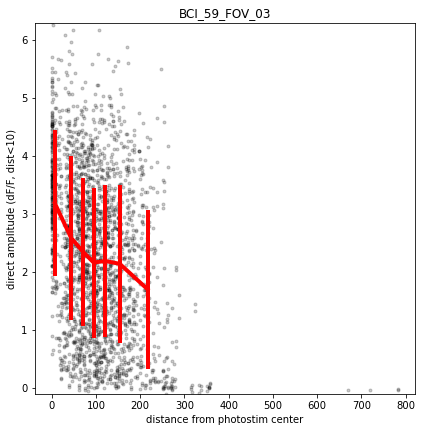

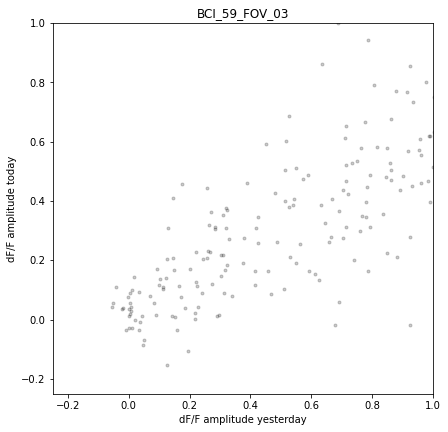

In [106]:
## ## need to add day-to-day reliability here

session_to_skip = -10 #5

slm_dict = {}
photostim_dict = {}
photostim_dist_edges = [0, 10]
lims = [-.25,1]
direct_photostim_distance = 10
for mouse in np.unique(multi_session_dict['mouse']):
    fovs = np.unique(np.asarray(multi_session_dict['fov'])[np.asarray(multi_session_dict['mouse'])==mouse])
    for fov in fovs:
        fovname = '{}_{}'.format(mouse,fov)
        
        all_distances = []
        all_amplitudes  = []
        
        all_yesterday_amplitudes = []
        all_today_amplitudes  = [] 
        session_i_real = 0
        for session_i in np.arange(len(multi_session_dict['photostim_distance'])):
            if multi_session_dict['mouse'][session_i] != mouse:
                continue
            if multi_session_dict['fov'][session_i] != fov:
                continue
            if len(multi_session_dict['photostim_distance'][session_i])==0:
                continue
            if session_i == session_to_skip:
                continue
            direct_cells = multi_session_dict['photostim_distance'][session_i]<direct_photostim_distance
            slm_distances = multi_session_dict['photostim_slm_distance'][session_i][direct_cells]
            amplitudes = multi_session_dict['photostim_amplitude'][session_i][direct_cells]
            all_distances.append(slm_distances)
            all_amplitudes.append(amplitudes)
            if session_i_real>0:
                if session_i == session_to_skip+1:
                    continue
                
                direct_cells = (multi_session_dict['photostim_distance'][session_i]<photostim_dist_edges[1]) & (multi_session_dict['photostim_distance'][session_i]>photostim_dist_edges[0])
                amplitudes = multi_session_dict['photostim_amplitude'][session_i][direct_cells]
                amplitudes_yesterday = multi_session_dict['photostim_amplitude'][session_i-1][direct_cells]
                all_yesterday_amplitudes.append(amplitudes_yesterday)
                all_today_amplitudes.append(amplitudes)
                
                    
            session_i_real += 1
        if len(all_distances)>0:
            slm_dict[fovname] = {'distances_from_slm_center':np.concatenate(all_distances),
                                 'amplitudes':np.concatenate(all_amplitudes)}
        if len(all_today_amplitudes)>0:
            photostim_dict[fovname] = {'amplitudes_yesterday':np.concatenate(all_yesterday_amplitudes),
                                 'amplitudes_today':np.concatenate(all_today_amplitudes)}
        

fig = plt.figure(figsize = [15,15])
bin_num_x=7
for fov_i,fov in enumerate(slm_dict.keys()):
    ax = fig.add_subplot(2,2,fov_i+1)
    ax.set_title(fov)
    dist = slm_dict[fov]['distances_from_slm_center']
    ampl = slm_dict[fov]['amplitudes']
    ax.plot(dist,ampl,'k.',alpha = .2)
    ax.set_xlabel('distance from photostim center')
    ax.set_ylabel('direct amplitude (dF/F, dist<{})'.format(direct_photostim_distance))
    ax.set_ylim(np.percentile(ampl,[.1,99.9]))
    
    
    
    x_sorted = np.sort(dist)
    x_starts = x_sorted[::int(np.floor(len(dist)/(bin_num_x)))-1]
    x_ends = x_starts[1:]
    x_starts = x_starts[:-1]   

    amp_list = []
    d_list = []
    amp_error_list = []
    
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (dist>=x_s)&(dist<=x_e)
        n = sum(needed_indices)
        amp_list.append(np.nanmean(ampl[needed_indices]))
        d_list.append(np.nanmean(dist[needed_indices]))
        amp_error_list.append(np.nanstd(ampl[needed_indices]))#/np.sqrt(n))
    ax.errorbar(d_list,amp_list,amp_error_list,color = 'red',linewidth = 4)

    
fig = plt.figure(figsize = [15,15])

for fov_i,fov in enumerate(photostim_dict.keys()):
    ax = fig.add_subplot(2,2,fov_i+1)
    ax.set_title(fov)
    x = photostim_dict[fov]['amplitudes_yesterday']
    y = photostim_dict[fov]['amplitudes_today']
    ax.plot(x,y,'k.',alpha = .2)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel('dF/F amplitude yesterday')
    ax.set_ylabel('dF/F amplitude today')

In [63]:
len(photostim_dist_edges_list)

51

In [101]:
session_to_skip = 5

slm_dict = {}
photostim_dict = {}
dist_edges = np.arange(0,50,1)
photostim_dist_edges_list = np.asarray([dist_edges[:-1], dist_edges[1:]]).T
amplitude_bins = np.arange(-1,8,.05)
for mouse in np.unique(multi_session_dict['mouse']):
    fovs = np.unique(np.asarray(multi_session_dict['fov'])[np.asarray(multi_session_dict['mouse'])==mouse])
    for fov in fovs:
        fovname = '{}_{}'.format(mouse,fov)
        photostim_dict[fovname] = {}
        photostim_dict[fovname]['amplitude_distribution_matrix']=[]
        for photostim_dist_edges in photostim_dist_edges_list:
            all_amplitudes  = [] 
            for session_i in np.arange(len(multi_session_dict['photostim_distance'])):
                if multi_session_dict['mouse'][session_i] != mouse:
                    continue
                if multi_session_dict['fov'][session_i] != fov:
                    continue
                if len(multi_session_dict['photostim_distance'][session_i])==0:
                    continue
                if session_i == session_to_skip:
                    continue
                direct_cells = (multi_session_dict['photostim_distance'][session_i]<photostim_dist_edges[1]) & (multi_session_dict['photostim_distance'][session_i]>photostim_dist_edges[0])
                amplitudes = multi_session_dict['photostim_amplitude'][session_i][direct_cells]
                all_amplitudes.append(amplitudes)

            if len(all_amplitudes)>0:
                y,x = np.histogram(np.concatenate(all_amplitudes),amplitude_bins)
                photostim_dict[fovname]['amplitude_distribution_matrix'].append(y/sum(y))
   
        

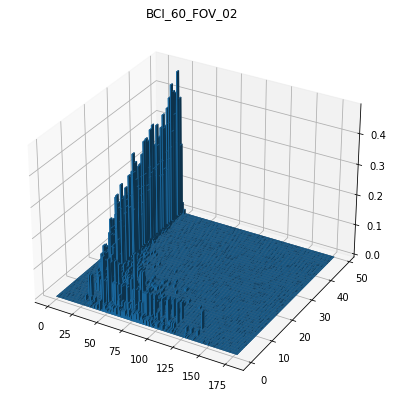

In [102]:

fig = plt.figure(figsize = [15,15])

for fov_i,fov in enumerate(photostim_dict.keys()):
    ax = fig.add_subplot(2,2,fov_i+1, projection='3d')
    ax.set_title(fov)
    data_array = np.asarray(photostim_dict[fovname]['amplitude_distribution_matrix'])#[::-1,:]
    x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )

    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = data_array.flatten()
    ax.bar3d( x_data,
              y_data,
              np.zeros(len(z_data)),
              1, 1, z_data )
   

#
# Finally, display the plot.
#
#plt.show()